In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from tensorflow import keras
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib.dates import DateFormatter
from statsmodels.stats.proportion import proportion_confint
import piecewise_regression
from sklearn import metrics
from numpy import sqrt, argmax

In [2]:
###Import of files
testing_dataset = pd.read_csv("ground_truth_testing_dataset.csv", sep=",")
merged_df = pd.read_csv("detections_testing_groundtruth.csv", sep=",")

merged_df['date'] = pd.to_datetime(merged_df['date'], format="%Y-%m-%d %H:%M:%S")

In [4]:
### Building of vectors (input of CNN models)

out = []
rfid_year_list = pd.DataFrame()
out3 = []
for start_year in range(2021, 2023):
    start_date = datetime.datetime(year=start_year-1, month=9, day=1)
    end_date = start_date + timedelta(days=517)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    # perform the grid search on time/rfid values
    values = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].last().unstack().reindex(dRange).fillna(method="ffill").fillna(False).astype(int).values
    values_detect_number = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].size().unstack().reindex(dRange).fillna(value=0).astype(int).values
    rfid_year = merged_df[merged_df["year"] == start_year][["rfid","year"]]
    # look for the corresponding breeding labels for this season
    out.extend(values.T)
    out3.extend(values_detect_number.T)
    if not rfid_year.empty:
        rfid_year_list = pd.concat([rfid_year_list, pd.DataFrame(rfid_year.drop_duplicates())])
        
final_value = [[0] for x in range(len(out))]
val = [[0,0] for x in range(975)]
for i in range(len(out)):
    for j in range(0,975):
        val[j] = [out[i][j+58],out3[i][j+58]]
    final_value[i]= np.array(val)
    
### Smaller vectors for determination of the sex    
final_value_425 = [i[0:425] for i in final_value]

In [5]:
###Import of models
model_NB_B = keras.models.load_model('models/model_determination_B_NB')
model_S_F = keras.models.load_model('models/model_determination_S_F')


In [6]:
### Predictions with the models
proba_NB_B = pd.DataFrame(model_NB_B.predict(np.array(final_value)), columns=['proba_NB','proba_B'])
prediction_NB_B = np.argmax(model_NB_B.predict(np.array(final_value)), axis=-1)
proba_S_F = pd.DataFrame(model_S_F.predict(np.array(final_value)), columns=['proba_F','proba_S'])
prediction_S_F = np.argmax(model_S_F.predict(np.array(final_value)), axis=-1)


data_proba = pd.DataFrame({'rfid': rfid_year_list["rfid"], 'year': rfid_year_list["year"], 'pred_NB_B': prediction_NB_B, 'pred_S_F': prediction_S_F})
data_proba.reset_index(inplace=True, drop=True)
data_proba = pd.merge(data_proba, proba_NB_B, left_index=True, right_index=True)
data_proba = pd.merge(data_proba, proba_S_F, left_index=True, right_index=True)

data_proba['pred_NB_B'] = data_proba['pred_NB_B'].replace(0, "NB")
data_proba['pred_NB_B'] = data_proba['pred_NB_B'].replace(1, "B")

data_proba['pred_S_F'] = data_proba['pred_S_F'].replace(0, "F")
data_proba['pred_S_F'] = data_proba['pred_S_F'].replace(1, "S")

pred_outcome = []
for i in range(len(data_proba)):
    if data_proba.iloc[i]["pred_NB_B"] == "B":
        pred_outcome.append(data_proba.iloc[i]["pred_S_F"])
    else:
        pred_outcome.append("NB")
data_proba["pred_outcome"] = pred_outcome

In [7]:
### Merge of result with the testing datasets

data_proba = data_proba.merge(testing_dataset, on=['rfid','year'])
print(data_proba)

                           rfid  year pred_NB_B pred_S_F      proba_NB  \
0    A 00000 0 964 000000911969  2021         B        S  5.018309e-05   
1    A 00000 0 964 000000912059  2021         B        F  1.388896e-04   
2    A 00000 0 964 000000912067  2021         B        S  6.424905e-05   
3    A 00000 0 964 000000912104  2021         B        S  1.951297e-05   
4    A 00000 0 964 000000912179  2021         B        S  5.302063e-06   
..                          ...   ...       ...      ...           ...   
296     R 0000 0000000046627110  2022         B        S  9.699470e-07   
297     R 0000 0000000055038569  2022         B        S  9.721343e-05   
298     R 0000 0000000072520688  2022         B        S  5.755661e-06   
299     R 0000 0000000072522975  2022         B        S  2.852485e-05   
300     R 0000 0000000088472092  2022         B        S  5.754453e-06   

      proba_B       proba_F   proba_S pred_outcome breeding_outcome  
0    0.999950  2.116584e-07  1.000000    

In [8]:
## Print of confusion matrices
print(confusion_matrix(data_proba["pred_outcome"], data_proba["breeding_outcome"], labels=["NB", "F", "S"]))

[[  0   0   0]
 [  0 146   6]
 [  0   6 143]]


In [9]:
sum(data_proba["pred_outcome"] == 'NB')

0

In [10]:
print('Global accuracy for F vs. S:')
print("Pred. vs. Dat. 1: " + str(sum(data_proba["pred_outcome"] == data_proba["breeding_outcome"])/len(data_proba)))

Global accuracy for F vs. S:
Pred. vs. Dat. 1: 0.9601328903654485


AUC scores for F vs. S: 
Pred. vs. Dat.1 AUC: 0.994878134934652
Best Threshold=0.826009, G-Mean=0.963


Text(0.2, 0.2, 'Best Threshold=0.826009, AUC=0.995')

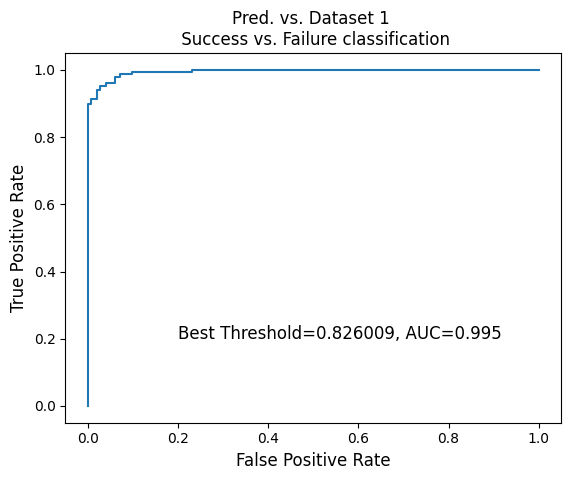

In [11]:
### AUC-ROC Curves for F vs. S:

print("AUC scores for F vs. S: ")
### Pred. vs. Dataset 1
data_proba_SF = copy.copy(data_proba)

data_proba_SF['breeding_outcome'] = data_proba_SF['breeding_outcome'].replace('F', 0)
data_proba_SF['breeding_outcome'] = data_proba_SF['breeding_outcome'].replace('S', 1)

fpr, tpr, thresholds = metrics.roc_curve(data_proba_SF['breeding_outcome'], data_proba_SF['proba_S'])

auc = metrics.roc_auc_score(data_proba_SF['breeding_outcome'], data_proba_SF['proba_S'])
print('Pred. vs. Dat.1 AUC: ' + str(auc))
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.title('Pred. vs. Dataset 1 \n Success vs. Failure classification')
plt.text(0.2, 0.2, 'Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc), fontsize = 12)
# plt.savefig('AUC_dataset1_success.pdf', bbox_inches='tight')